# Fully convolutional semantic segmentation

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

In this notebook, we retrain the VGG16 model to carry out 'fully convolutional' semantic segmentation

We will implement the approach of [Long et al. 2015](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)

![](figs/Slide47.PNG)

![](figs/Slide48.PNG)

We'll use the Grand Canyon sandbars data set. First we'll copy over the files from S3 to our local drive, then we'll train the model, and test the model outputs

![](figs/dl_tools_fullyconv.png)

## Preparing the data

### Looking at the S3 file structure

Let's load in our s3fs library and explore the contents of the 'fully_conv_semseg' folder

In [1]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
root = 'esipfed/cdi-workshop'

In [2]:
fs.ls(root+'/fully_conv_semseg')

['esipfed/cdi-workshop/fully_conv_semseg/vgg.zip',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc',
 'esipfed/cdi-workshop/fully_conv_semseg/data_ontario',
 'esipfed/cdi-workshop/fully_conv_semseg/data_seabright',
 'esipfed/cdi-workshop/fully_conv_semseg/vgg_graph']

In [3]:
fs.ls(root+'/fully_conv_semseg/data_gc/labels/gtFine/train/gc')

['esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0089L_20161113_0758_gtFine_color.png',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0089L_20161113_0758_mres.mat',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0307Rf_20161106_1157_gtFine_color.png',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0307Rf_20161106_1157_mres.mat',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0414R_20131119_1358_gtFine_color.png',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0414R_20131119_1358_mres.mat',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0450L_20131118_0757_gtFine_color.png',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0450L_20131118_0757_mres.mat',
 'esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0515L_20141117_1558_gtFine_color.png',
 'esipfed/cdi

### Creating samples

You'll see a very specific folder structure for each of the datasets

* top_level (data_gc)
    * samples
        * RGB
            * train or val
                * site name (gc)
            
* top_level (data_gc)
    * labels
        * gtFine
            * train (or val)
                * site name (gc)            

In [4]:
direc = root+'/fully_conv_semseg/data_gc/samples/RGB/train/gc'
files = [f for f in fs.ls(direc) if f.endswith('.png')]
len(files)

7

Create data structure for samples (images to train with)

In [5]:
import os
os.mkdir('data') ##root+os.sep+
os.mkdir('data'+os.sep+'samples')  
os.mkdir('data'+os.sep+'samples'+os.sep+'RGB')
os.mkdir('data'+os.sep+'samples'+os.sep+'RGB'+os.sep+'train')
os.mkdir('data'+os.sep+'samples'+os.sep+'RGB'+os.sep+'val')
os.mkdir('data'+os.sep+'samples'+os.sep+'RGB'+os.sep+'train'+os.sep+'data')
os.mkdir('data'+os.sep+'samples'+os.sep+'RGB'+os.sep+'val'+os.sep+'data')

Next we need to copy over the files we need (this takes a while):

In [6]:
from imageio import imread, imwrite
for file in files:
    print("working on ",file)
    with fs.open(file, 'rb') as fim:
        image = imread(fim)   
        imwrite('data'+os.sep+'samples'+os.sep+'RGB'+os.sep+'train'+os.sep+'data'+os.sep+file.split('/')[-1], image)

working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/train/gc/RC0089L_20161113_0758_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/train/gc/RC0307Rf_20161106_1157_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/train/gc/RC0414R_20131119_1358_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/train/gc/RC0450L_20131118_0757_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/train/gc/RC0515L_20141117_1558_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/train/gc/RC0566R_20161113_1157_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/train/gc/RC0658L_20141117_0959_RGB.png


This next bit finds the 'validation' files and copies them over

In [7]:
direc = root+'/fully_conv_semseg/data_gc/samples/RGB/val/gc'
files = [f for f in fs.ls(direc) if f.endswith('.png')]
len(files)

7

In [8]:
for file in files:
    print("working on ",file)
    with fs.open(file, 'rb') as fim:
        image = imread(fim)   
        imwrite('data'+os.sep+'samples'+os.sep+'RGB'+os.sep+'val'+os.sep+'data'+os.sep+file.split('/')[-1], image)

working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/val/gc/RC0089L_20140925_0929_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/val/gc/RC0307Rf_20131118_1346_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/val/gc/RC0414R_20141109_1558_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/val/gc/RC0450L_20161113_0756_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/val/gc/RC0515L_20131118_1358_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/val/gc/RC0566R_20131111_1158_RGB.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/samples/RGB/val/gc/RC0658L_20131111_1359_RGB.png


### Creating labels

We recreate the file structure for the labels

In [9]:
!pwd

/home/jovyan/cdi_dl_workshop/Day2


In [10]:
os.mkdir('data'+os.sep+'labels')
os.mkdir('data'+os.sep+'labels'+os.sep+'gtFine')
os.mkdir('data'+os.sep+'labels'+os.sep+'gtFine'+os.sep+'train')
os.mkdir('data'+os.sep+'labels'+os.sep+'gtFine'+os.sep+'val')
os.mkdir('data'+os.sep+'labels'+os.sep+'gtFine'+os.sep+'train'+os.sep+'data')
os.mkdir('data'+os.sep+'labels'+os.sep+'gtFine'+os.sep+'val'+os.sep+'data') 

In [11]:
direc = root+'/fully_conv_semseg/data_gc/labels/gtFine/train/gc'
files = [f for f in fs.ls(direc) if f.endswith('.png')]
len(files)

7

In [12]:
for file in files:
    print("working on ",file)
    with fs.open(file, 'rb') as fim:
        image = imread(fim)   
        imwrite('data'+os.sep+'labels'+os.sep+'gtFine'+os.sep+'train'+os.sep+'data'+os.sep+file.split('/')[-1], image)

working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0089L_20161113_0758_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0307Rf_20161106_1157_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0414R_20131119_1358_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0450L_20131118_0757_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0515L_20141117_1558_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0566R_20161113_1157_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/train/gc/RC0658L_20141117_0959_gtFine_color.png


In [13]:
direc = root+'/fully_conv_semseg/data_gc/labels/gtFine/val/gc'
files = [f for f in fs.ls(direc) if f.endswith('.png')]

for file in files:
    print("working on ",file)
    with fs.open(file, 'rb') as fim:
        image = imread(fim)   
        imwrite('data'+os.sep+'labels'+os.sep+'gtFine'+os.sep+'val'+os.sep+'data'+os.sep+file.split('/')[-1], image)

working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/val/gc/RC0089L_20140925_0929_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/val/gc/RC0307Rf_20131118_1346_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/val/gc/RC0414R_20141109_1558_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/val/gc/RC0450L_20161113_0756_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/val/gc/RC0515L_20131118_1358_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/val/gc/RC0566R_20131111_1158_gtFine_color.png
working on  esipfed/cdi-workshop/fully_conv_semseg/data_gc/labels/gtFine/val/gc/RC0658L_20131111_1359_gtFine_color.png


### Create a labeldefs.txt file

We need to tell the program what the classes are and what RGB color they correspond to in the label imagery

First, let's change directory and run the code in the 'semseg_fullyconv' folder

In [14]:
import os
os.chdir('semseg_fullyconv/')

In [15]:
!pwd

/home/jovyan/cdi_dl_workshop/Day2/semseg_fullyconv


Specify labels and associated red, green, and blue colors

In [16]:
labels = ['rock','water','veg','sand','other']
r = [102, 0, 0, 255, 255]
g = [51, 0, 255, 255, 0]
b = [0, 255, 0, 0, 0]

In [17]:
with open('labeldefs.txt', 'a') as f:
    for item in range(len(labels)):
        f.write(labels[item]+','+str(r[item])+','+str(g[item])+','+str(b[item])+'\n')

In [18]:
!cat labeldefs.txt

rock,102,51,0
water,0,0,255
veg,0,255,0
sand,255,255,0
other,255,0,0


## Training the Net

For illustrative purposes, to save time we are going to train the model using just 15 epochs. For real applications, you would want to train for tens to hundreds of epochs

In [19]:
out_direc = 'data_test10'
data_source = 'data'
data_dir = '../data'
num_epochs=15

While the model trains, we'll watch a video that explains what the VGG model is

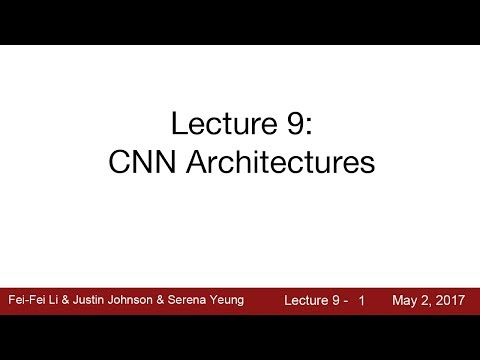

In [20]:
from IPython.display import YouTubeVideo
from datetime import timedelta

start=int(timedelta(hours=0, minutes=14, seconds=40).total_seconds())

YouTubeVideo("DAOcjicFr1Y", start=start)

Now we train the model by calling 'train.py'

It is actually set up to download the correct model (VGG 16) from the internet before retraining it

In [21]:
%run train.py --name $out_direc --data-source $data_source \
                                 --data-dir $data_dir --epochs $num_epochs

0.00B [00:00, ?B/s]

[i] Project name:          data_test10
[i] Data source:           data
[i] Data directory:        ../data
[i] VGG directory:         vgg_graph
[i] # epochs:              15
[i] Batch size:            20
[i] Tensorboard directory: tb
[i] Checkpoint interval:   50
[i] Creating directory data_test10...
[i] Configuring data source...
[i] # training samples:    7
[i] # validation samples:  7
[i] # classes:             5
[i] Image size:            (512, 256)
[i] Creating the model...


997MB [00:20, 49.5MB/s]                               


INFO:tensorflow:Restoring parameters from vgg_graph/vgg/variables/variables
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



[i] Epoch  1/15:   0%|          | 0/1 [00:00<?, ?batches/s]

[i] Training...


[i] Epoch 15/15: 100%|██████████| 1/1 [00:49<00:00, 49.52s/batches]


Checkpoint saved: data_test10/final.ckpt


### Tidying up

Remove the VGG graph

In [22]:
#!rm vgg.zip
#!rm -rf vgg_graph/

## Testing the model

First we specify an output directory, and point the program to the location of the 'test' images

In [30]:
samps_dir = '../data/samples/RGB/val/data'
output = 'test_output'

In [31]:
%run ./infer.py --name $out_direc --samples-dir $samps_dir \
                                 --output-dir $output --data-source $data_source

ERROR:root:File `'./infer.py'` not found.


Take a look in the output folder. The labeling looks 'blobby' because
* we didn't train the model for very long
* there is no post-processing

## Testing the model with CRF post-processing

This time we'll run the inference with CRF post processing to try to get more refined label images

In [25]:
%run ./infer_crf.py --name $out_direc --samples-dir $samps_dir \
                                 --output-dir $output --data-source $data_source

[i] Project name:       data_test10
[i] Network checkpoint: data_test10/final.ckpt
[i] Metagraph file:     data_test10/final.ckpt.meta
[i] Number of samples:  7
[i] Output directory:   test_output
[i] Image size:         (512, 256)
[i] # classes:          5
[i] Batch size:         20
[i] Creating the model...
INFO:tensorflow:Restoring parameters from data_test10/final.ckpt


[i] Processing samples:   0%|          | 0/1 [00:00<?, ?batches/s]/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:179: UserWarning: Downcasting int64 to uint8 without scaling because max value 4 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:179: UserWarning: Downcasting int64 to uint8 without scaling because max value 3 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
[i] Processing samples: 100%|██████████| 1/1 [01:13<00:00, 73.44s/batches]

[i] All done.


Take a look in the output folder again - you'll see a new set of files

### Tidying up  ____STOP HERE unless you want to DELETE everything

To remove the model, tensorboard info, and outputs:

In [26]:
#!rm -rf data_test10
#!rm -rf tb
#!rm -rf test_output

Remove the labeldefs.txt file

In [27]:
#!rm labeldefs.txt

change directory

In [28]:
os.chdir('..')
!pwd

/home/jovyan/cdi_dl_workshop/Day2


Delete the 'data' directory that we copied over from S3 earlier

In [29]:
#!rm -rf data

## DL-tools

The equivalent function in DL-tools is called and is the same as used here. The key is getting the data in a strict format such as we did here. Then the functions are executed in the following sequence

1. ```python semseg_fullyconv\make_labels.py```
   * this function creates label rgb images from class data in the .mat files
2. ```python semseg_fullyconv\train.py```
    * this function trains the network
3. ```python semseg_fullyconv\infer.py``` or ```python semseg_fullyconv\infer_crf.py```
    * this function carries out the semantic segmentation